In [1]:
from functools import partial
import itertools
import json
from pathlib import Path
import re
import sys
sys.path.append("../src")

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from tqdm import tqdm, tqdm_notebook

%matplotlib inline
sns.set(style="whitegrid", context="paper", font_scale=3.5, rc={"lines.linewidth": 2.5})
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
#set_matplotlib_formats('svg')

%load_ext autoreload
%autoreload 2
import util

In [2]:
sprobe_results_path = Path("~/om2/others/structural-probes/bert").expanduser()
sprobe_glove_path = Path("~/om2/others/structural-probes/glove").expanduser()

In [3]:
# Path to BERT directory, containing model checkpoints
bert_path = Path("~/om2/others/bert").expanduser()
# Base model used as init checkpoint for finetuning
bert_base_model = "uncased_L-12_H-768_A-12"
# Fine-tuning tasks / models
bert_models = ["_", "SQuAD", "QQP", "MNLI", "SST", "LM", "LM_lmonly", "LM_scrambled_para", "LM_scrambled", "LM_lmonly_scrambled", "LM_contentonly", "LM_contentonly_scrambled", "LM_randommask", "LM_pos"]
# Models which should appear in the final report figures
report_models = ["SQuAD", "QQP", "MNLI", "SST", "LM", "LM_scrambled", "LM_scrambled_para", "LM_pos"]
checkpoint_steps = list(range(5,255,5))
# Describes the particular fine-tuning regime used
finetune_desc = "finetune-250"
target_runs = [1, 2, 3, 4, 5, 6, 7, 8, 9]

In [4]:
RENDER_FINAL = True
figure_path = Path("../reports/figures")
figure_path.mkdir(exist_ok=True)

report_hues = dict(zip(sorted(report_models), sns.color_palette()))

## Collect results

In [66]:
eval_results = {}
for eval_dir in tqdm_notebook(list(sprobe_results_path.glob("%s.%s.*" % (finetune_desc, bert_base_model)))):
    if not eval_dir.is_dir(): continue
    try:
        model, run, step, layer = re.findall(r"\.([\w_]+)-run(\d+)-(\d+)-layer(\d+)$", eval_dir.name)[0]
    except IndexError: continue
    run, step, layer = int(run), int(step), int(layer)
    
    try:
        uuas_file = list(eval_dir.glob("**/dev.uuas"))[0]
        with uuas_file.open("r") as f:
            uuas = float(f.read().strip())
    except: continue
        
    try:
        spearman_file = list(eval_dir.glob("**/dev.spearmanr-*-mean"))[0]
        with spearman_file.open("r") as f:
            spearman = float(f.read().strip())
    except: continue
        
    eval_results[model, run, step, layer] = pd.Series({"uuas": uuas, "spearman": spearman})

### Add baseline results

In [67]:
baseline_dir = sprobe_results_path / ("%s-layer11" % bert_base_model)
assert baseline_dir.exists()

In [68]:
with list(baseline_dir.glob("**/dev.uuas"))[0].open("r") as f:
    baseline_uuas = float(f.read().strip())
        
with list(baseline_dir.glob("**/dev.spearmanr-*-mean"))[0].open("r") as f:
    baseline_spearman = float(f.read().strip())

In [69]:
to_update = set((model, run) for model, run, _, _ in eval_results.keys())
for model, run in to_update:
    eval_results[model, run, 0, 11] = pd.Series({"uuas": baseline_uuas, "spearman": baseline_spearman})

### Add non-BERT results

In [70]:
nonbert_models = []

In [71]:
# GloVe
for glove_dir in tqdm_notebook(list(sprobe_glove_path.glob("*"))):
    if not glove_dir.is_dir(): continue
    model = glove_dir.name
    
    try:
        uuas_file = list(glove_dir.glob("**/dev.uuas"))[0]
        with uuas_file.open("r") as f:
            uuas = float(f.read().strip())
    except: continue
        
    try:
        spearman_file = list(glove_dir.glob("**/dev.spearmanr-*-mean"))[0]
        with spearman_file.open("r") as f:
            spearman = float(f.read().strip())
    except: continue
        
    nonbert_models.append(model)
    eval_results[model, 1, 250, 0] = pd.Series({"uuas": uuas, "spearman": spearman})

### Aggregate

In [72]:
eval_results = pd.DataFrame(pd.concat(eval_results, names=["model", "run", "step", "layer", "metric"]))

In [73]:
eval_results.tail(20)

0
model                   run step layer metric            
SST                     8   250  0     uuas      0.409932
                                       spearman  0.588946
                                 3     uuas      0.468479
                                       spearman  0.645804
                                 6     uuas      0.469092
                                       spearman  0.664289
                                 9     uuas      0.438847
                                       spearman  0.610961
                                 10    uuas      0.420762
                                       spearman  0.580319
                                 11    uuas      0.399203
                                       spearman  0.545367
en_wikitext_glove16     1   250  0     uuas      0.257382
                                       spearman  0.330957
en_wikitext_glove32     1   250  0     uuas      0.256463
                                       spearman  0.327360
en_wikitext_glove64     1   250  0     uuas      0.256156
                                       spearman  0.321590
spaCy-en_vectors_web_lg 1   250  0     uuas      0.268622
                                       spearman  0.323490

In [74]:
# Only use spaCy results
nonbert_models_to_graph = [("spaCy-en_vectors_web_lg", "GloVe")]

## Graph

In [75]:
graph_data = eval_results.reset_index()
graph_data = graph_data[~graph_data.model.isin(nonbert_models)]

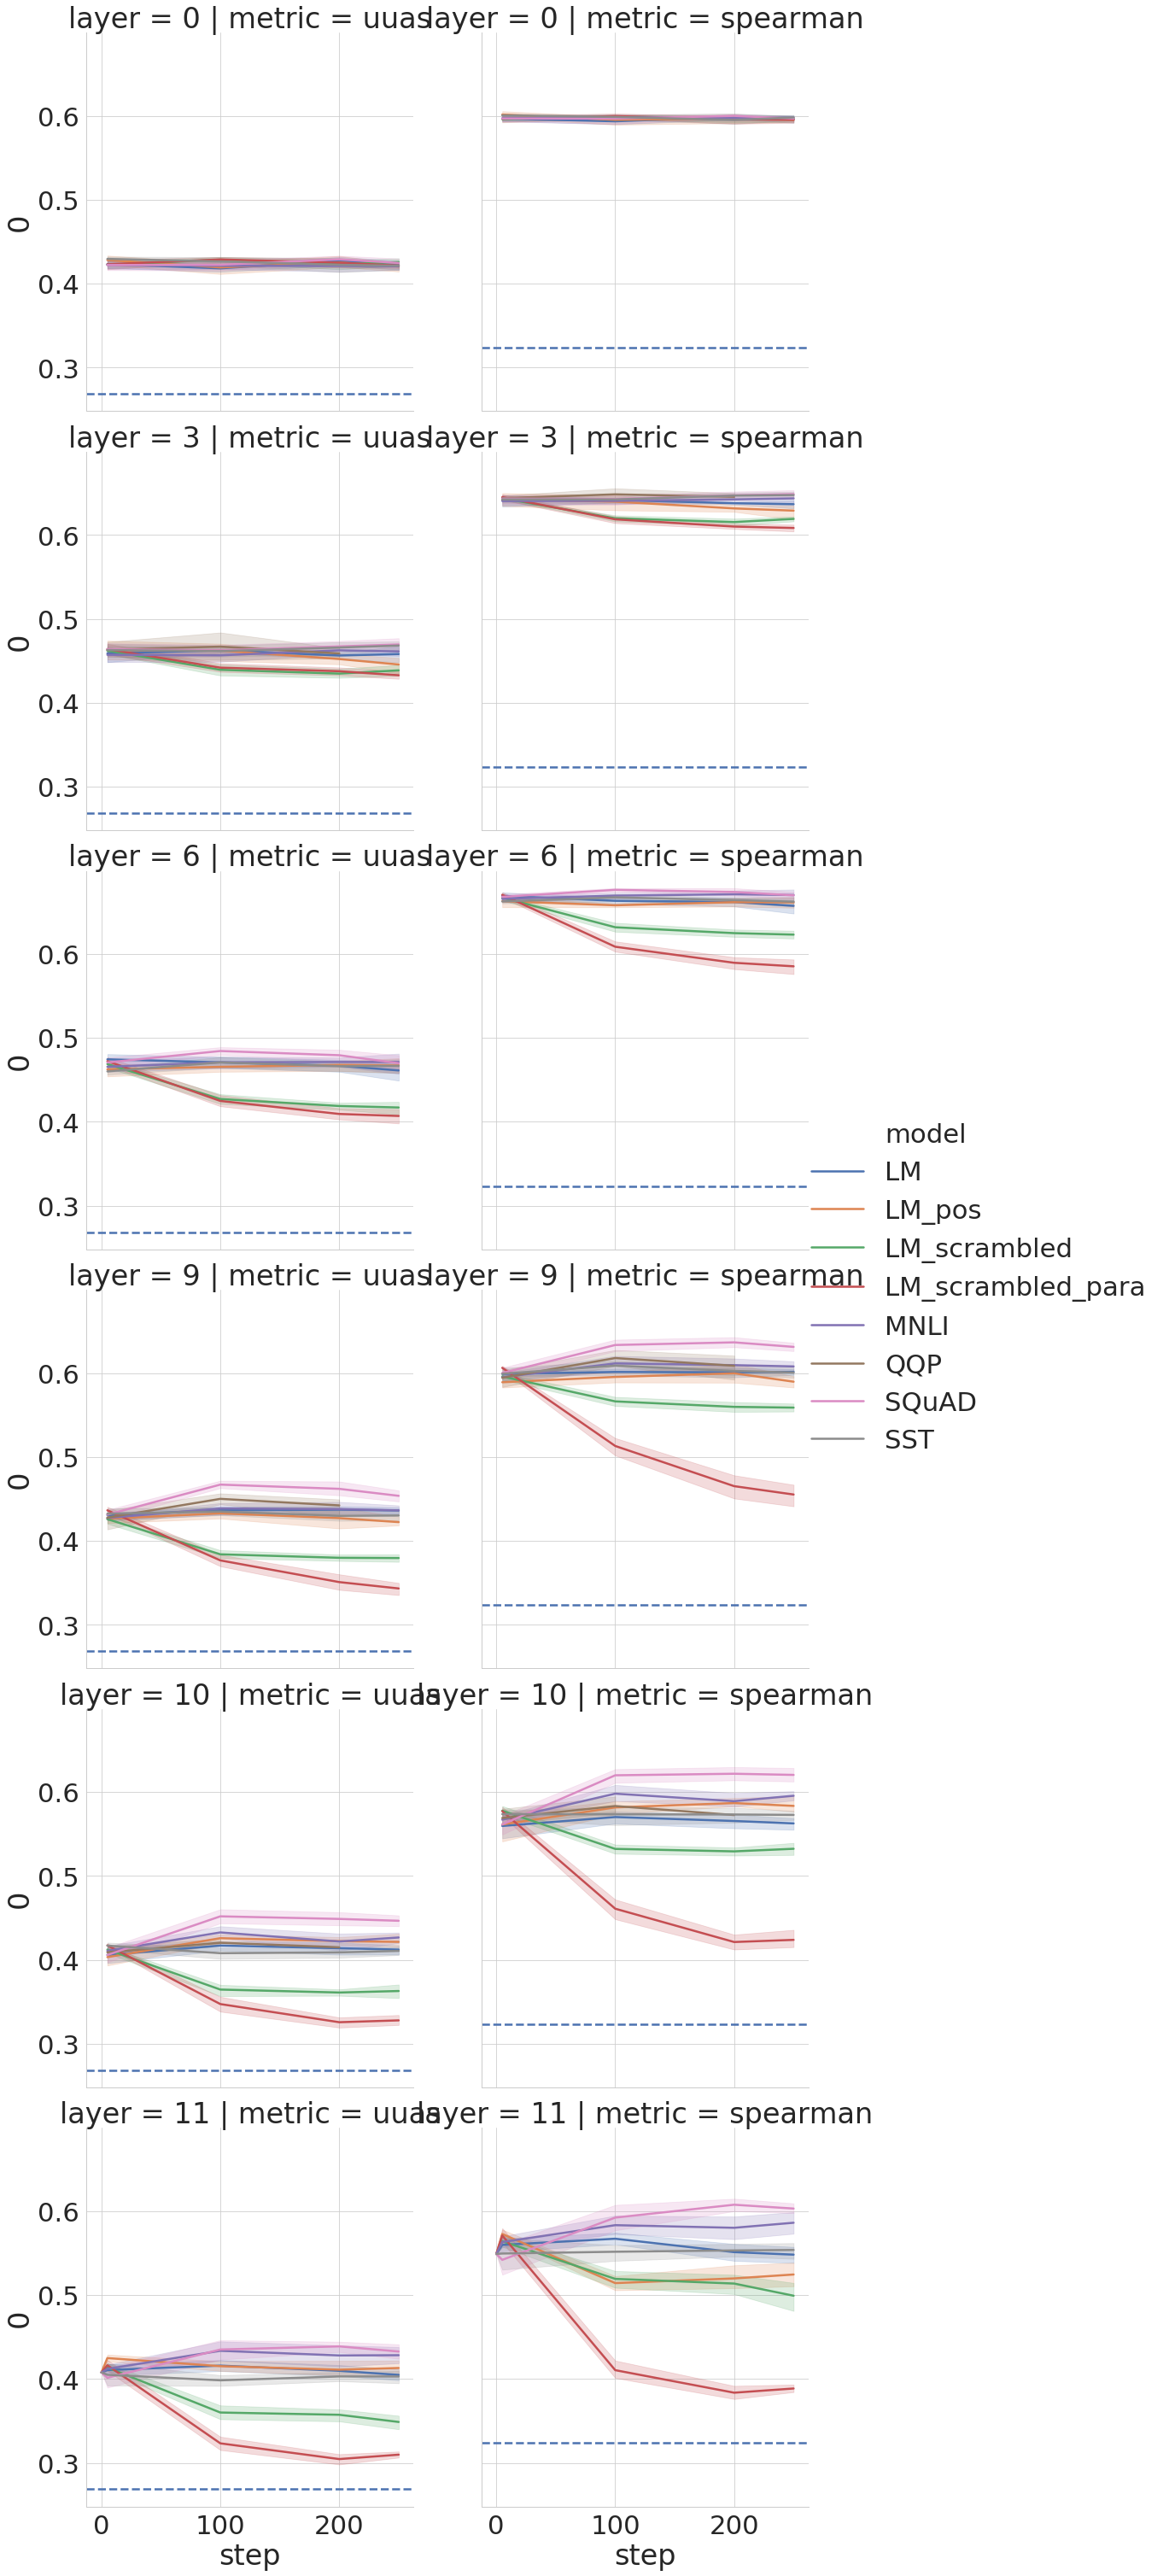

In [30]:
g = sns.FacetGrid(data=graph_data, col="metric", row="layer", height=7, sharex=True, sharey=True)
g.map(sns.lineplot, "step", 0, "model")

for uuas_ax in g.axes[:, 0]:
    for nonbert_model, label in nonbert_models_to_graph:
        uuas_ax.axhline(eval_results.loc[nonbert_model, 1, 250, 0, "uuas"][0], linestyle='--', label=label)
for spearman_ax in g.axes[:, 1]:
    for nonbert_model, label in nonbert_models_to_graph:
        spearman_ax.axhline(eval_results.loc[nonbert_model, 1, 250, 0, "spearman"][0], linestyle='--', label=label)
        
g.add_legend()
g

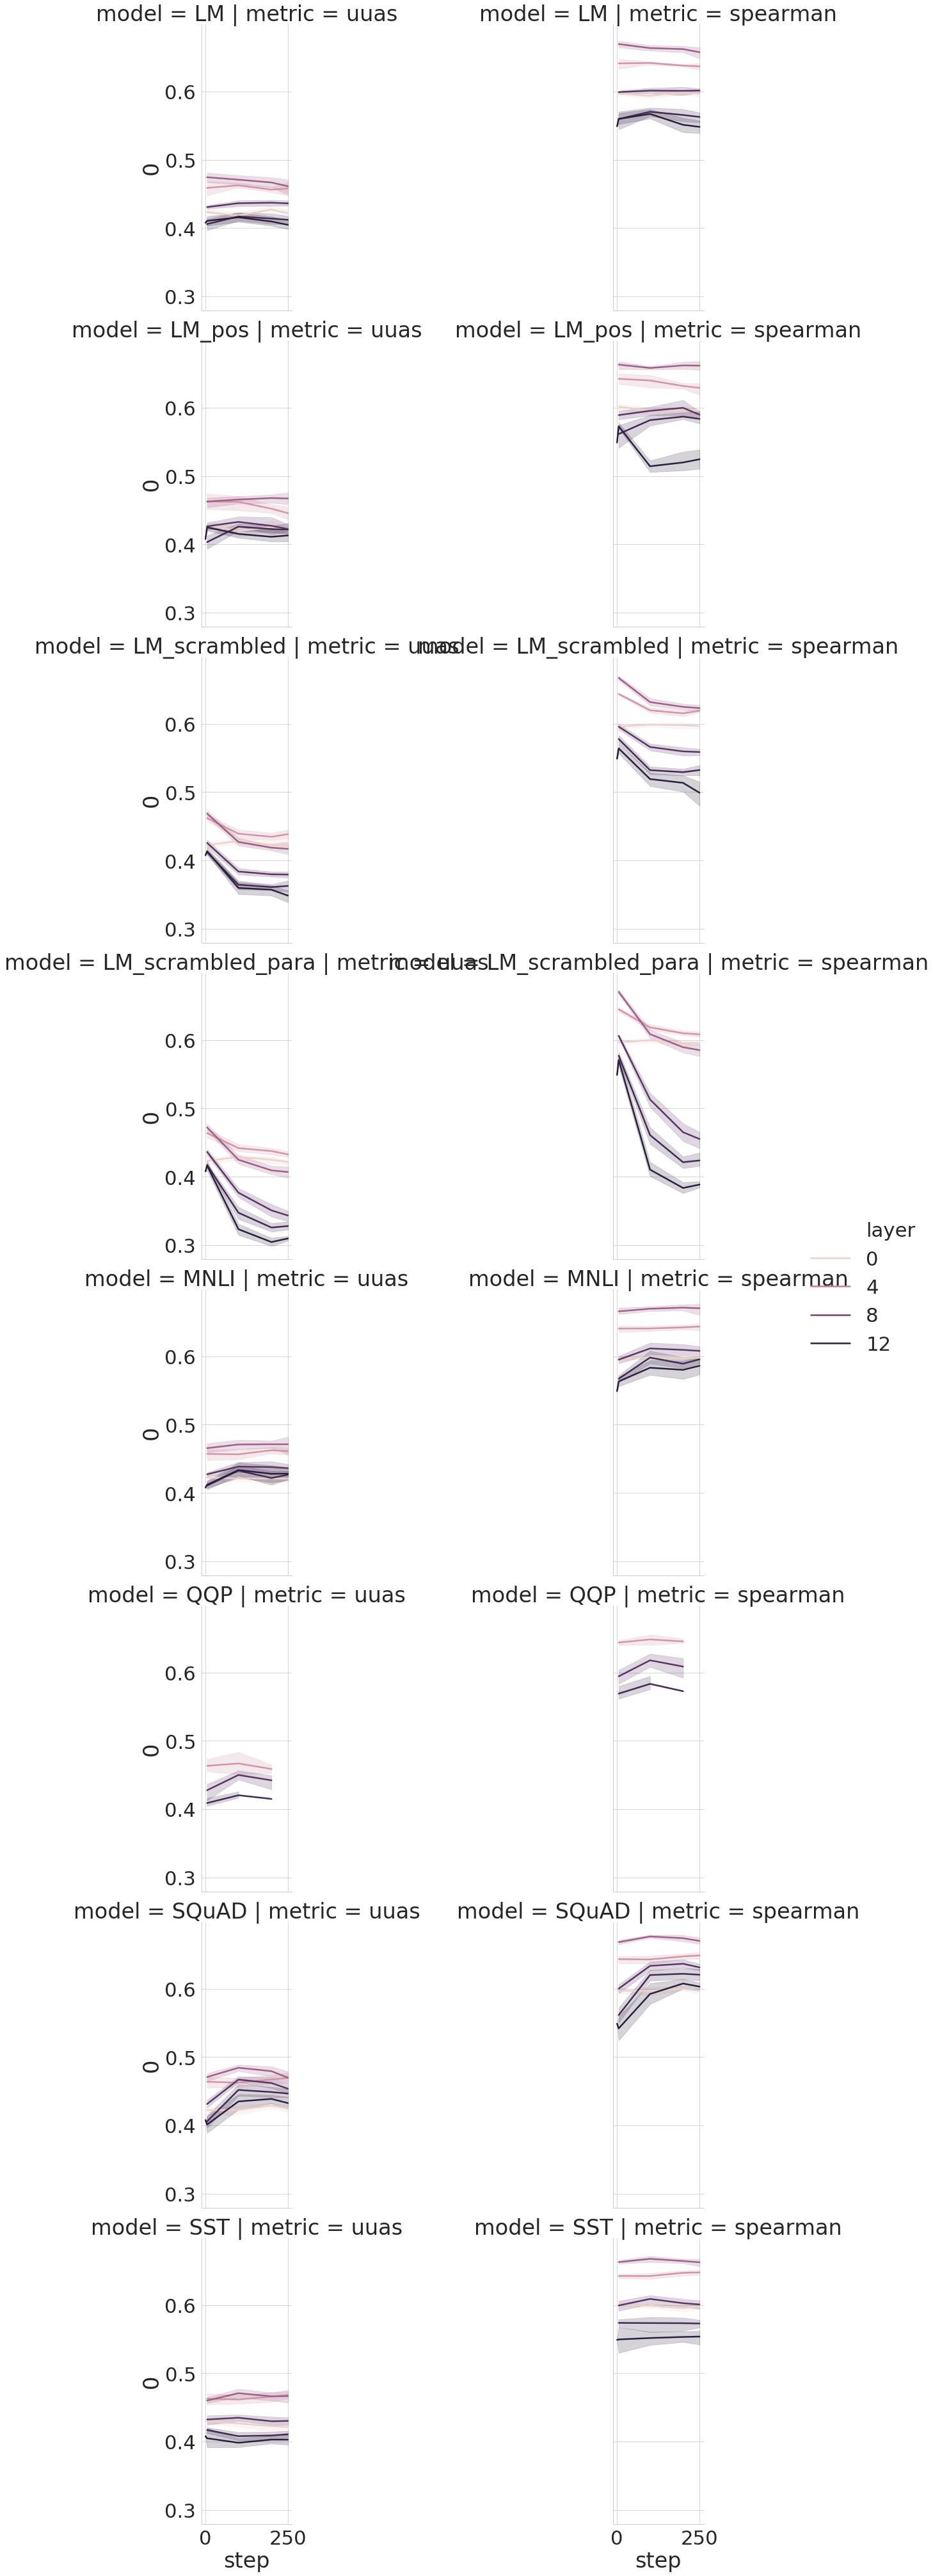

In [31]:
g = sns.FacetGrid(data=graph_data, col="metric", row="model", height=7, sharex=True, sharey=True)
g.map(sns.lineplot, "step", 0, "layer").add_legend()

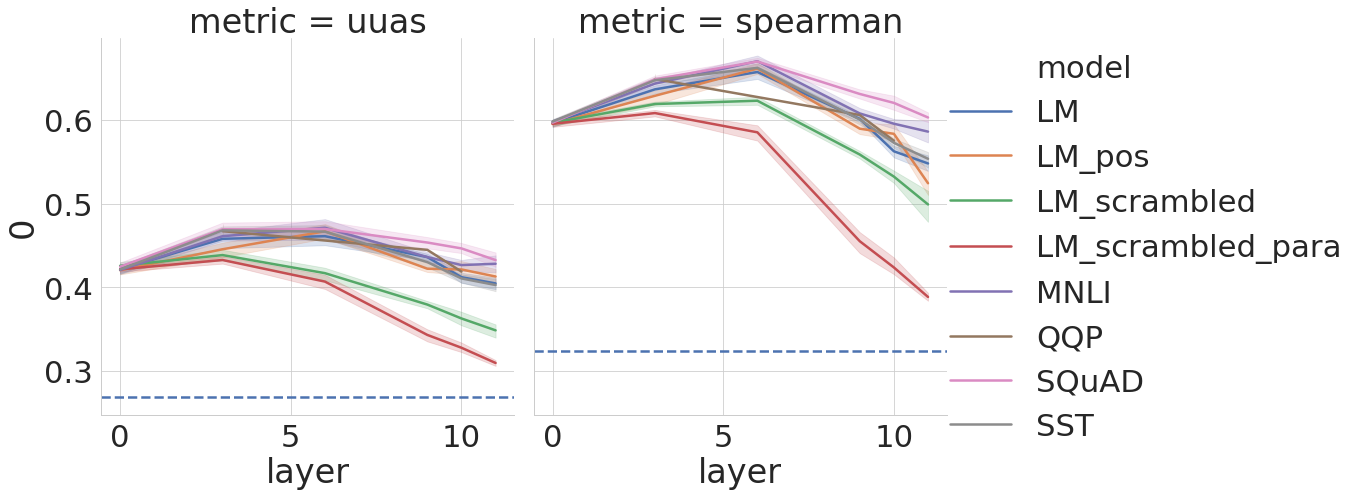

In [50]:
g = sns.FacetGrid(data=graph_data[graph_data.step == checkpoint_steps[-1]], col="metric", height=7, sharex=True, sharey=True)
g.map(sns.lineplot, "layer", 0, "model")

uuas_ax, spearman_ax = g.axes[0]
for nonbert_model, label in nonbert_models_to_graph:
    uuas_ax.axhline(eval_results.loc[nonbert_model, 1, 250, 0, "uuas"][0], linestyle='--', label=label)
    spearman_ax.axhline(eval_results.loc[nonbert_model, 1, 250, 0, "spearman"][0], linestyle='--', label=label)
    
g.add_legend()

In [64]:
graph_data[(graph_data.metric == "uuas") & (graph_data.layer == 11) & (graph_data.model == "QQP")]

,model,run,step,layer,metric,0
1800,QQP,1,0,11,uuas,0.407786
1812,QQP,1,5,11,uuas,0.421375
1820,QQP,1,100,11,uuas,0.446817
1828,QQP,1,200,11,uuas,0.443548
1836,QQP,1,250,11,uuas,0.444672
1838,QQP,2,0,11,uuas,0.407786
1846,QQP,2,5,11,uuas,0.433841
1854,QQP,2,100,11,uuas,0.407786
1862,QQP,2,200,11,uuas,0.417799
1870,QQP,2,250,11,uuas,0.425462


In [76]:
%matplotlib agg

if RENDER_FINAL:
    dir = figure_path / "structural_probe"
    dir.mkdir(exist_ok=True)
    
    for metric, label in [("uuas", "UUAS"), ("spearman", "Spearman correlation")]:
        fig = plt.figure(figsize=(15, 9))
        ax = sns.lineplot(data=graph_data[(graph_data.metric == metric) & (graph_data.layer == 11)], x="step", y=0,
                          hue="model", palette=report_hues)
        for nonbert_model, nonbert_label in nonbert_models_to_graph:
            ax.axhline(eval_results.loc[nonbert_model, 1, 250, 0, metric][0], linestyle='--', label=nonbert_label, linewidth=3)
            
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        plt.xlim((0, checkpoint_steps[-1]))
        plt.ylabel(label)
        plt.xlabel("Training step")
        plt.tight_layout()
        plt.savefig(dir / ("%s.pdf" % metric))
        plt.close()
    
%matplotlib inline